In [33]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from niwtools.tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)


In [34]:
from xarrayutils.vertical_remapping import xr_remapping

In [372]:
path = '../data/xarray/qc_7781a.nc'
data = xr.open_dataset(path)
data = data.sel(time=slice('2016-10-04','2016-10-19'))
data.coords['z'] = -data.z
data['rho'] = data.rho0- 1000

data['rho'] = xr.where(data.rho<20, np.nan, data.rho)

In [373]:
data

<xarray.Dataset>
Dimensions:   (time: 215, z: 501)
Coordinates:
  * time      (time) datetime64[ns] 2016-10-04T00:39:31.322976 ... 2016-10-19T22:42:41.728779
  * z         (z) float64 0.0 1.985 3.969 5.954 ... 984.0 986.0 988.0 989.9
    pressure  (z) float64 ...
    lat       (time) float64 ...
    lon       (time) float64 ...
Data variables:
    sigma     (z, time) float64 ...
    T         (z, time) float64 ...
    S         (z, time) float64 ...
    n2        (z, time) float64 ...
    rho0      (z, time) float64 nan nan 1.023e+03 nan ... nan nan nan nan
    u         (z, time) float64 ...
    v         (z, time) float64 ...
    dudz      (z, time) float64 ...
    dvdz      (z, time) float64 ...
    kT        (z, time) float64 ...
    chi       (z, time) float64 ...
    eps       (z, time) float64 ...
    rho       (z, time) float64 nan nan 23.42 nan 23.47 ... nan nan nan nan nan
Attributes:
    floatid:  7781a

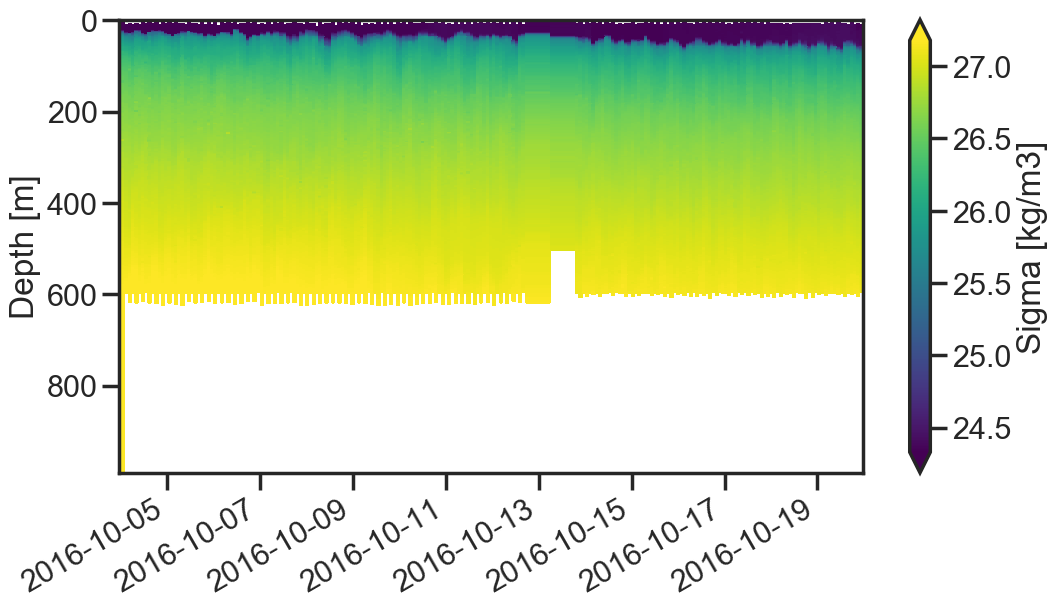

In [374]:
data.rho.plot(cbar_kwargs={'label':'Sigma [kg/m3]'}, yincrease=False, robust=True)
plt.ylabel('Depth [m]');
plt.xlabel(None);

## Switching to density coordinates using linear interpolation

In [375]:
from xarrayutils.vertical_coordinates import linear_interpolation_regrid

In [480]:
rho_min = data.rho.min()
rho_max = data.rho.max()

sigma_vals = np.arange(rho_min,rho_max, 0.01)
sigma_values = xr.DataArray(sigma_vals, coords=[('sigma', sigma_vals)]) # define the new temperature grid

z_sigma_coord = linear_interpolation_regrid(data.z, data.rho, sigma_values, target_value_dim='sigma')
# z_sigma_coord = z_sigma_coord.fillna(0)

In [481]:
data['rho_ref'] = data.rho.rolling(time=25).mean()

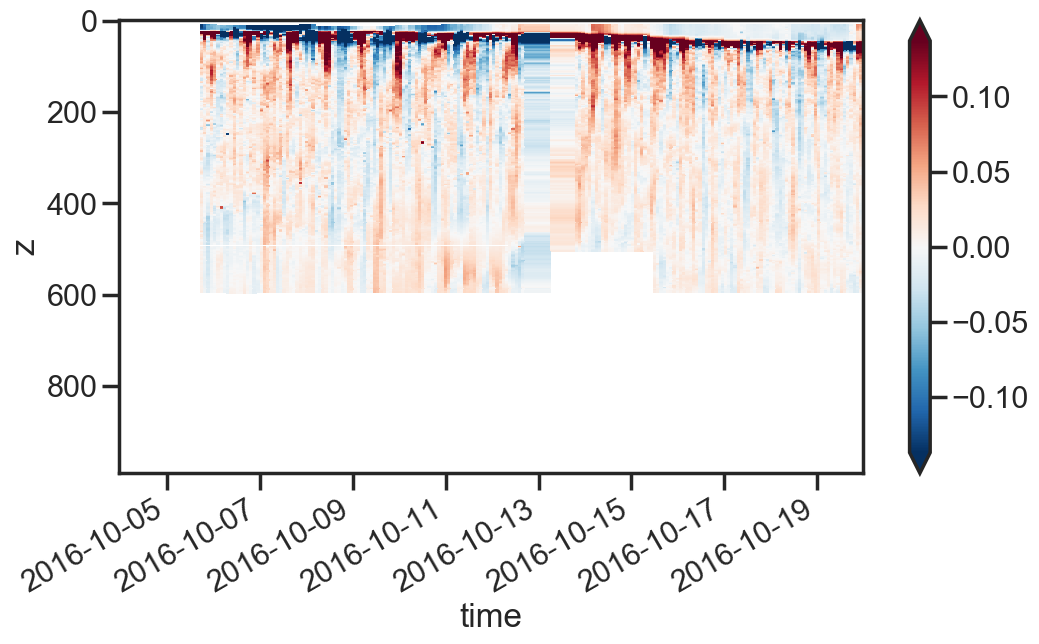

In [482]:
(data.rho_ref-data.rho).plot(yincrease=False, robust=True)

In [541]:
data.rho_ref

<xarray.DataArray 'rho_ref' (z: 501, time: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) datetime64[ns] 2016-10-04T00:39:31.322976 ... 2016-10-19T22:42:41.728779
  * z         (z) float64 0.0 1.985 3.969 5.954 ... 984.0 986.0 988.0 989.9
    pressure  (z) float64 ...
    lat       (time) float64 ...
    lon       (time) float64 ...

In [483]:
z_sigma_coord_ref = linear_interpolation_regrid(data.z, data.rho_ref, sigma_values, target_value_dim='sigma')
# z_sigma_coord_ref = z_sigma_coord.fillna(0)

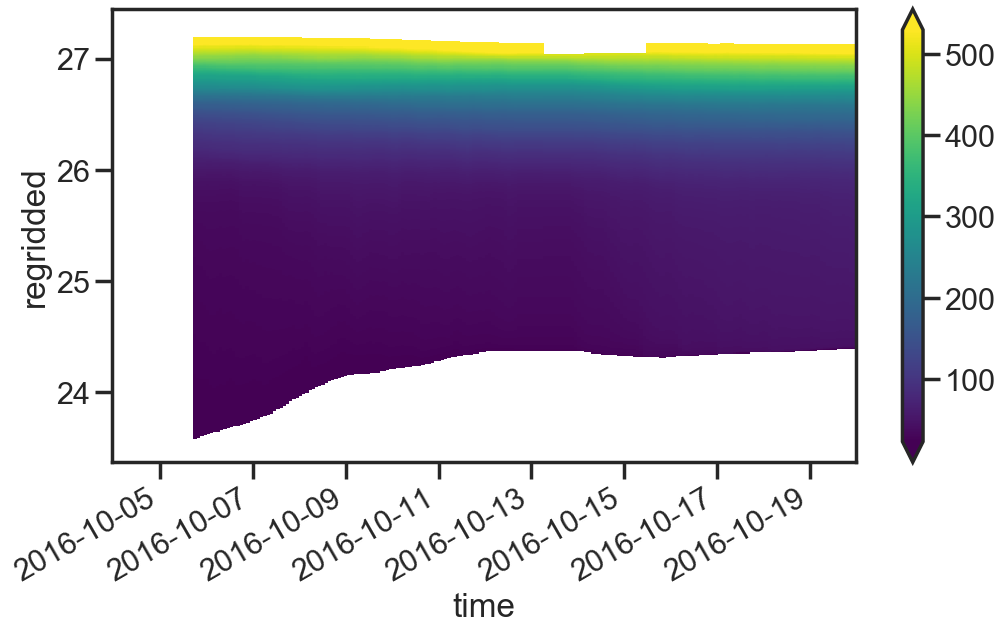

In [484]:
z_sigma_coord_ref.plot(x='time', robust=True)

## Remapping other variable onto sigma coordinates

In [765]:
data['hke'] = data.u**2+ data.v**2

In [766]:
ds_temp_linear = linear_interpolation_remap(data.z, data.hke, z_sigma_coord)

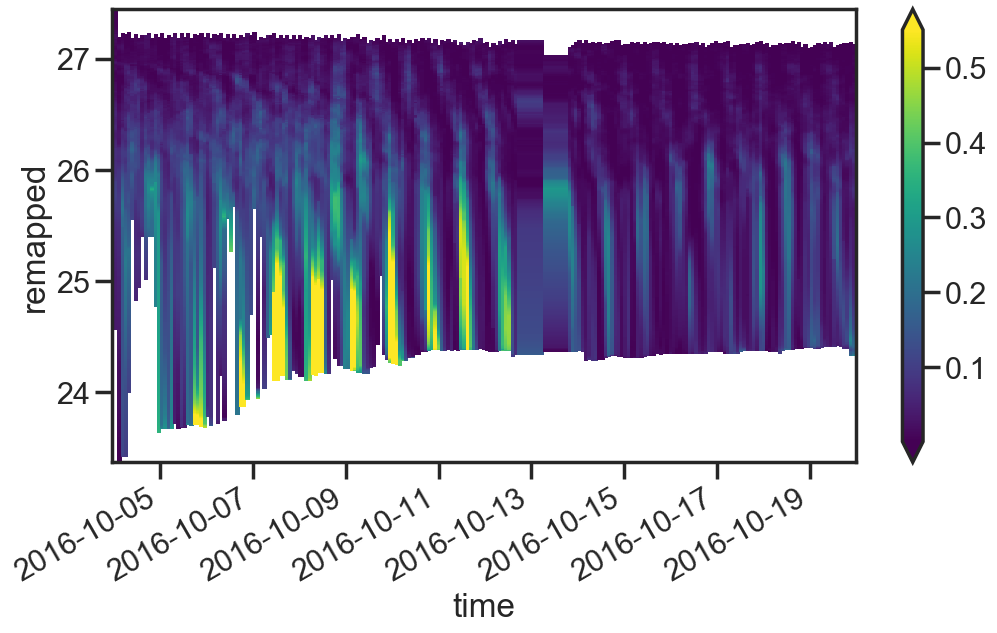

In [767]:
ds_temp_linear.plot(x='time', robust=True)

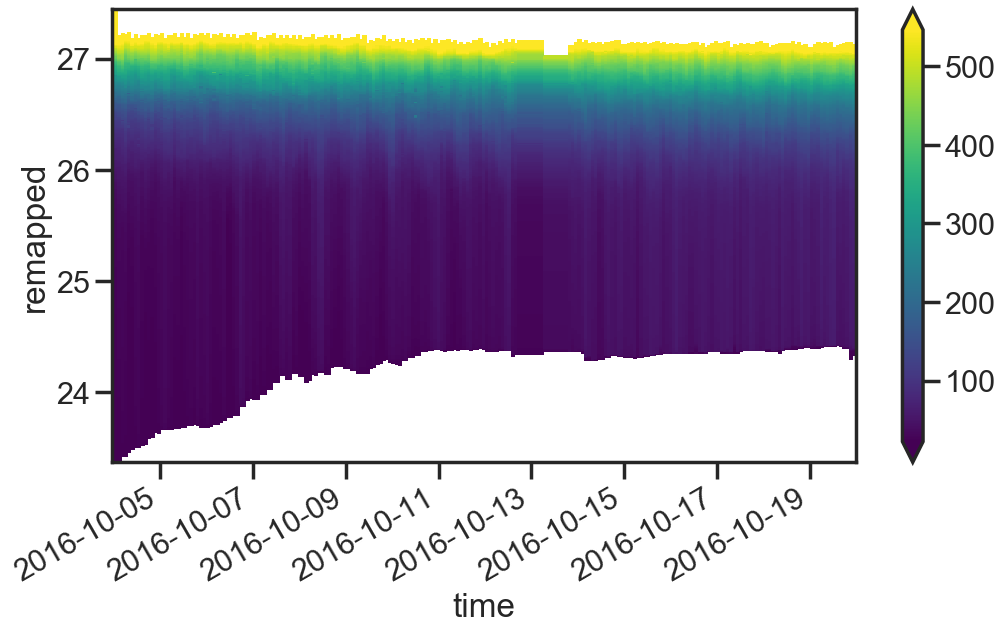

In [786]:
data['sigma'],data['zmap'] = xr.broadcast(data.rho,data.z)
ds_z_linear = linear_interpolation_remap(data.z, data.zmap, z_sigma_coord)
ds_z_linear.plot(x='time', robust=True)

## Compute isopycnal displacement

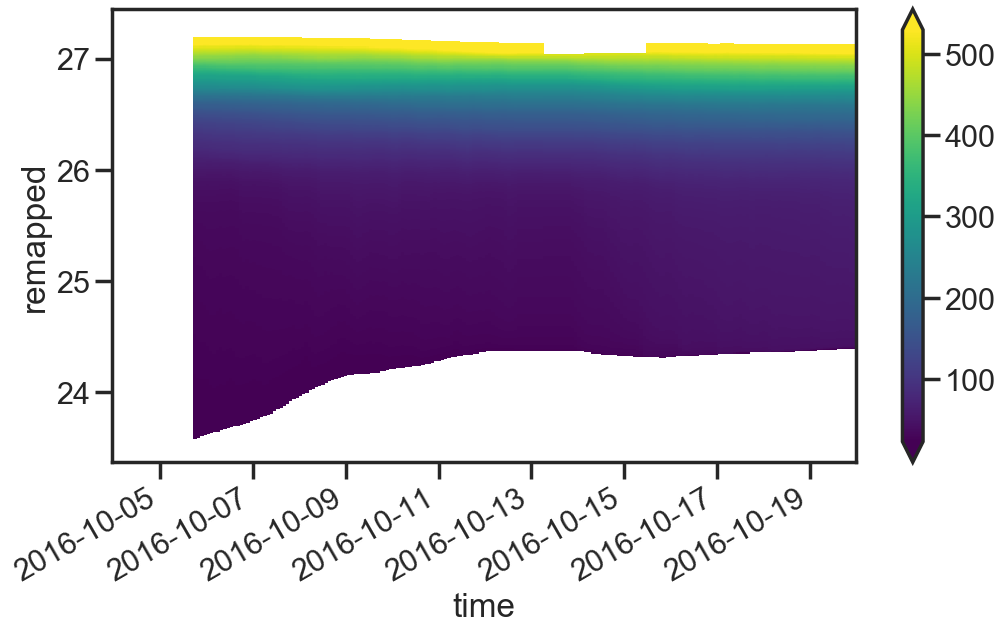

In [793]:
data['sigma'],data['zmap'] = xr.broadcast(data.rho_ref,data.z)
ds_z_ref = linear_interpolation_remap(data.z, data.zmap, z_sigma_coord_ref)
ds_z_ref.plot(x='time', robust=True)

## Project back onto z coordinates

In [788]:
rho_min = data.rho.min()
rho_max = data.rho.max()

# sigma_vals = np.arange(rho_min,rho_max, 0.01)
# sigma_values = xr.DataArray(sigma_vals, coords=[('sigma', sigma_vals)]) # define the new temperature grid
z_values = xr.DataArray(data.z.values, coords=[('z', data.z.values)]) # define the new z grid

# z_coord = linear_interpolation_regrid(data.z, data.rho, sigma_values, target_value_dim='sigma')
z_coord = linear_interpolation_regrid(ds_z_linear.remapped, ds_z_linear.transpose(), z_values, target_value_dim='z') 

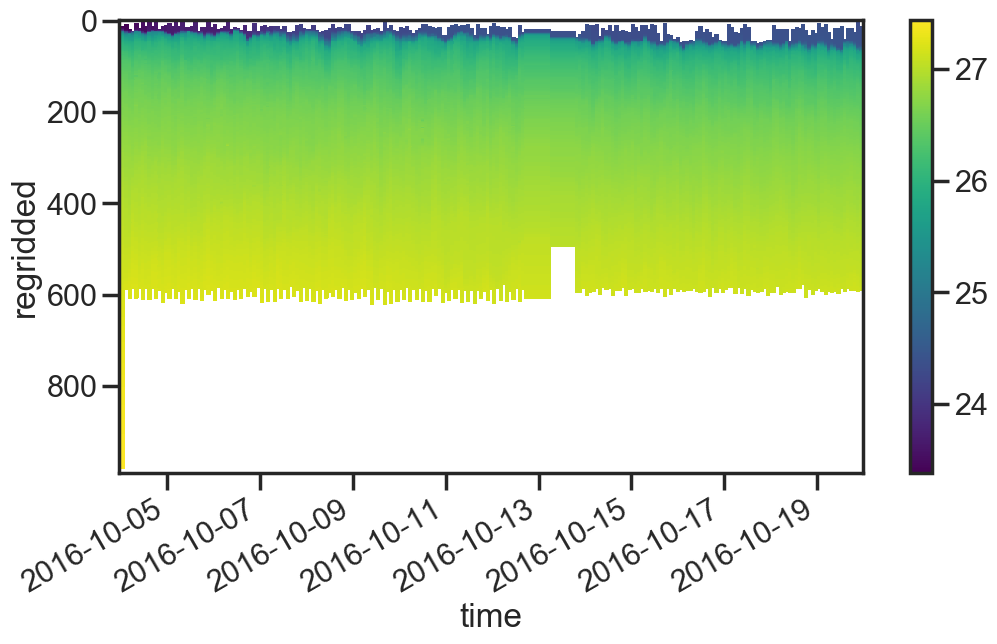

In [789]:
z_coord.plot(x='time', yincrease=False)

In [790]:
ds_z_linear = ds_z_linear.rename({'remapped':'sigma'})
ds_z_ref = ds_z_ref.rename({'remapped':'sigma'})
ds_z_linear = ds_z_linear-ds_z_ref

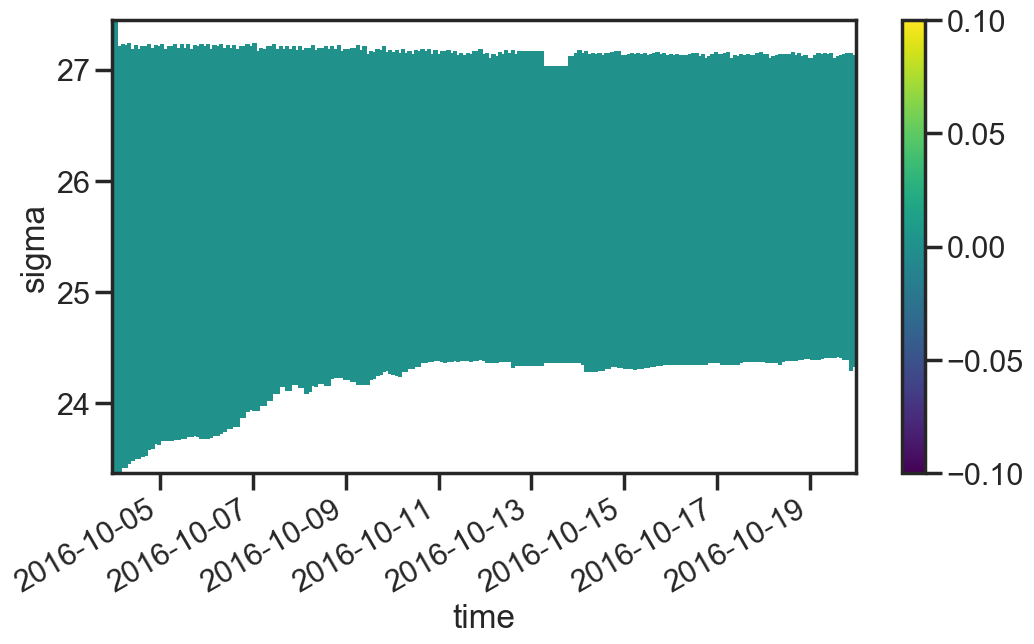

In [791]:
ds_z_linear.plot(x='time')

In [792]:
ds_z_linear = ds_z_linear.fillna(1e-20)
eta = linear_interpolation_remap(ds_z_linear.sigma, ds_z_linear, z_coord)
data['eta'] = eta.rename({'remapped':'z'}).transpose()
try:
    data = data.drop('remapped')
except:
    None
data['eta'] = data.eta.where(data.eta.pipe(np.abs)>1e-20)

(200, 0)

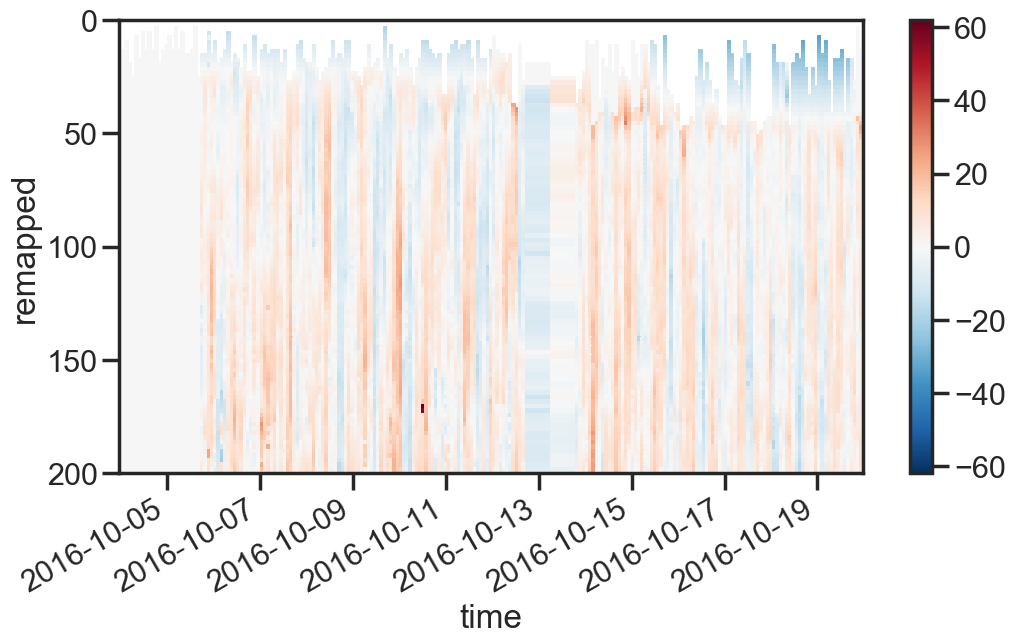

In [782]:
eta.plot(x='time', yincrease=False)
plt.ylim(200,0)

(200, 0)

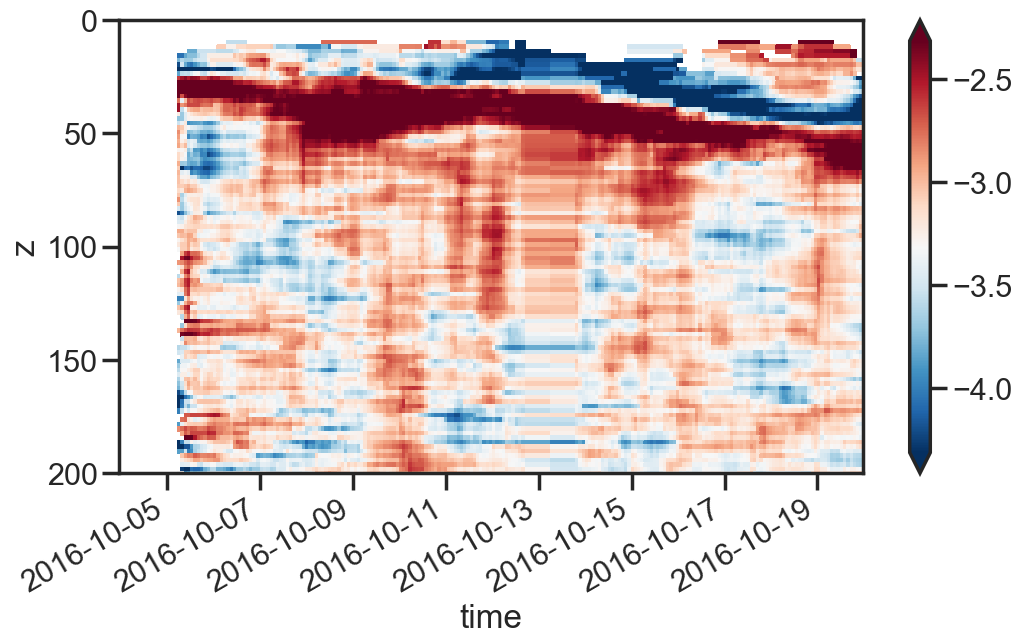

In [785]:
(data.n2*data.eta.pipe(lambda x: x**2)).pipe(np.log10).rolling(time=18, center=True, min_periods=2).mean().plot(
    yincrease=False, robust=True, cmap='RdBu_r')
plt.ylim(200,0)